# Object-base colocalization live-coding
by Dominic Waithe

In [1]:
#Libraries to import.
%matplotlib inline
import pylab as plt
from tifffile import imread
import numpy as np
from skimage.filters import threshold_otsu
from scipy import ndimage
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import flood_fill
from skimage.morphology import watershed
import find_maxima
import pandas as pd 


def find_local_maxima_np(img_data):
    #This is the numpy/scipy version of the above function (find local maxima).
    #Its a bit faster, and more compact code.
    
    #Filter data with maximum filter to find maximum filter response in each neighbourhood
    max_out = ndimage.filters.maximum_filter(img_data,size=3)
    #Find local maxima.
    local_max = np.zeros((img_data.shape))
    local_max[max_out == img_data] = 1
    local_max[img_data == np.min(img_data)] = 0
    return local_max.astype(np.bool)


In [32]:
#import images. Unfortunately I was unable to share these files.
#You will have to substitute them with your own images.
img_name = '2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ'
ch0 = imread('june18imgs/'+img_name+'_w435.tif').astype(np.float64)
ch1 = imread('june18imgs/'+img_name+'_w594.tif').astype(np.float64)
ch2 = imread('june18imgs/'+img_name+'_w676.tif').astype(np.float64)

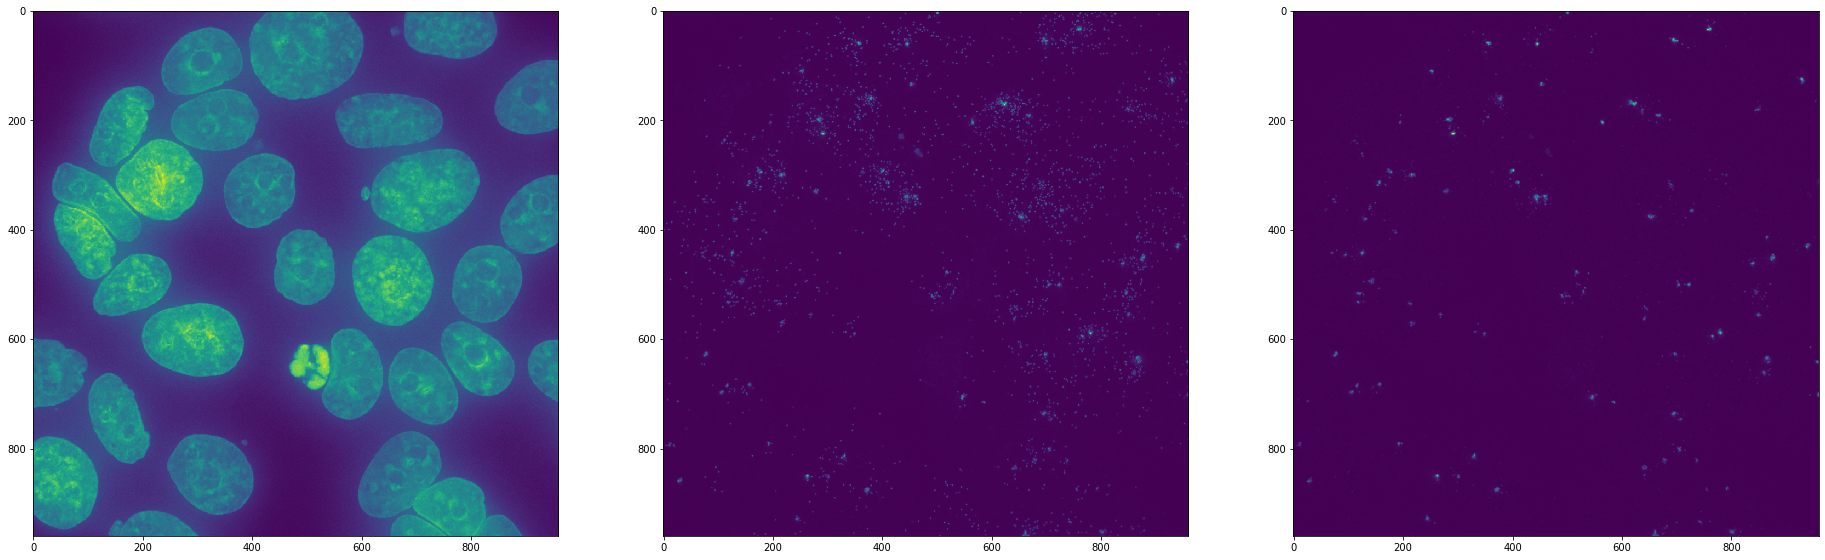

In [10]:
#Plotting.
plt.figure(figsize=(32,32))
plt.subplot(1,3,1)
plt.imshow(ch0)
plt.subplot(1,3,2)
plt.imshow(ch1)
plt.subplot(1,3,3)
plt.imshow(ch2)

### Histogram-based thresholding.

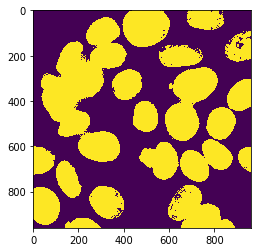

In [11]:

thresh = threshold_otsu(ch0)
binary = ch0 > thresh
plt.imshow(binary)

### Watershed segmentation.

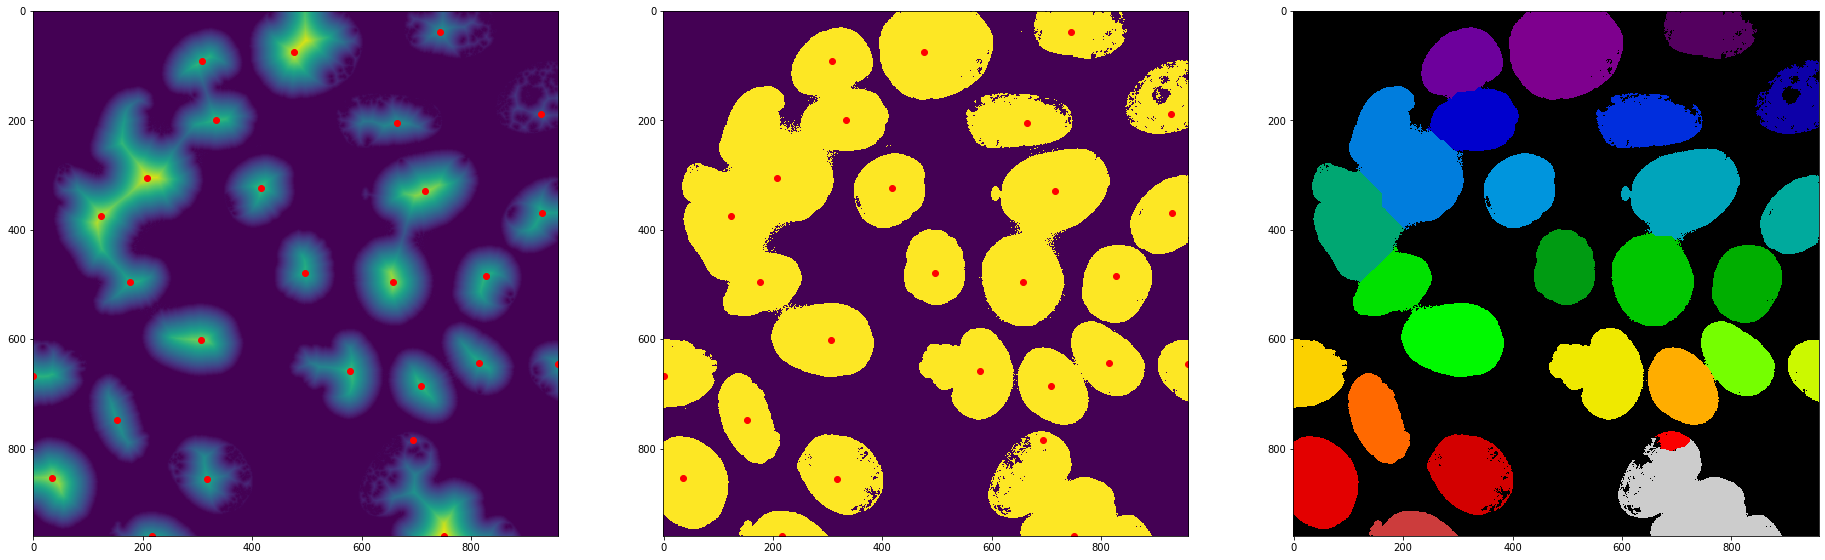

In [47]:


dist = ndimage.distance_transform_edt(binary)
#plt.imshow(dist)

ntol = 15
img_data = np.array(dist).astype(np.float64)
img_data = (img_data/np.max(img_data))*255

local_max = find_local_maxima_np(img_data)
#plt.figure(figsize=(32,32))
#plt.imshow(local_max)

y,x,out, = find_maxima.find_maxima(img_data, local_max.astype(np.uint8),ntol)

#plt.plot(x,y,'ro')


local_maxi = np.zeros(ch0.shape)
local_maxi[y,x] = 1
markers, num = ndimage.label(local_maxi)

labels = watershed(-dist, markers, mask=binary)

data = {'img':img_name, 'cell_num':np.arange(1,num+1),'pts_ch1':None,'pts_ch2':None}


df = pd.DataFrame(data)



plt.figure(figsize=(32,32))
plt.subplot(1,3,1)
plt.plot(x,y,'ro')
plt.imshow(dist)
plt.subplot(1,3,2)
plt.plot(x,y,'ro')
plt.imshow(binary)
plt.subplot(1,3,3)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

### Object-based colocalization.

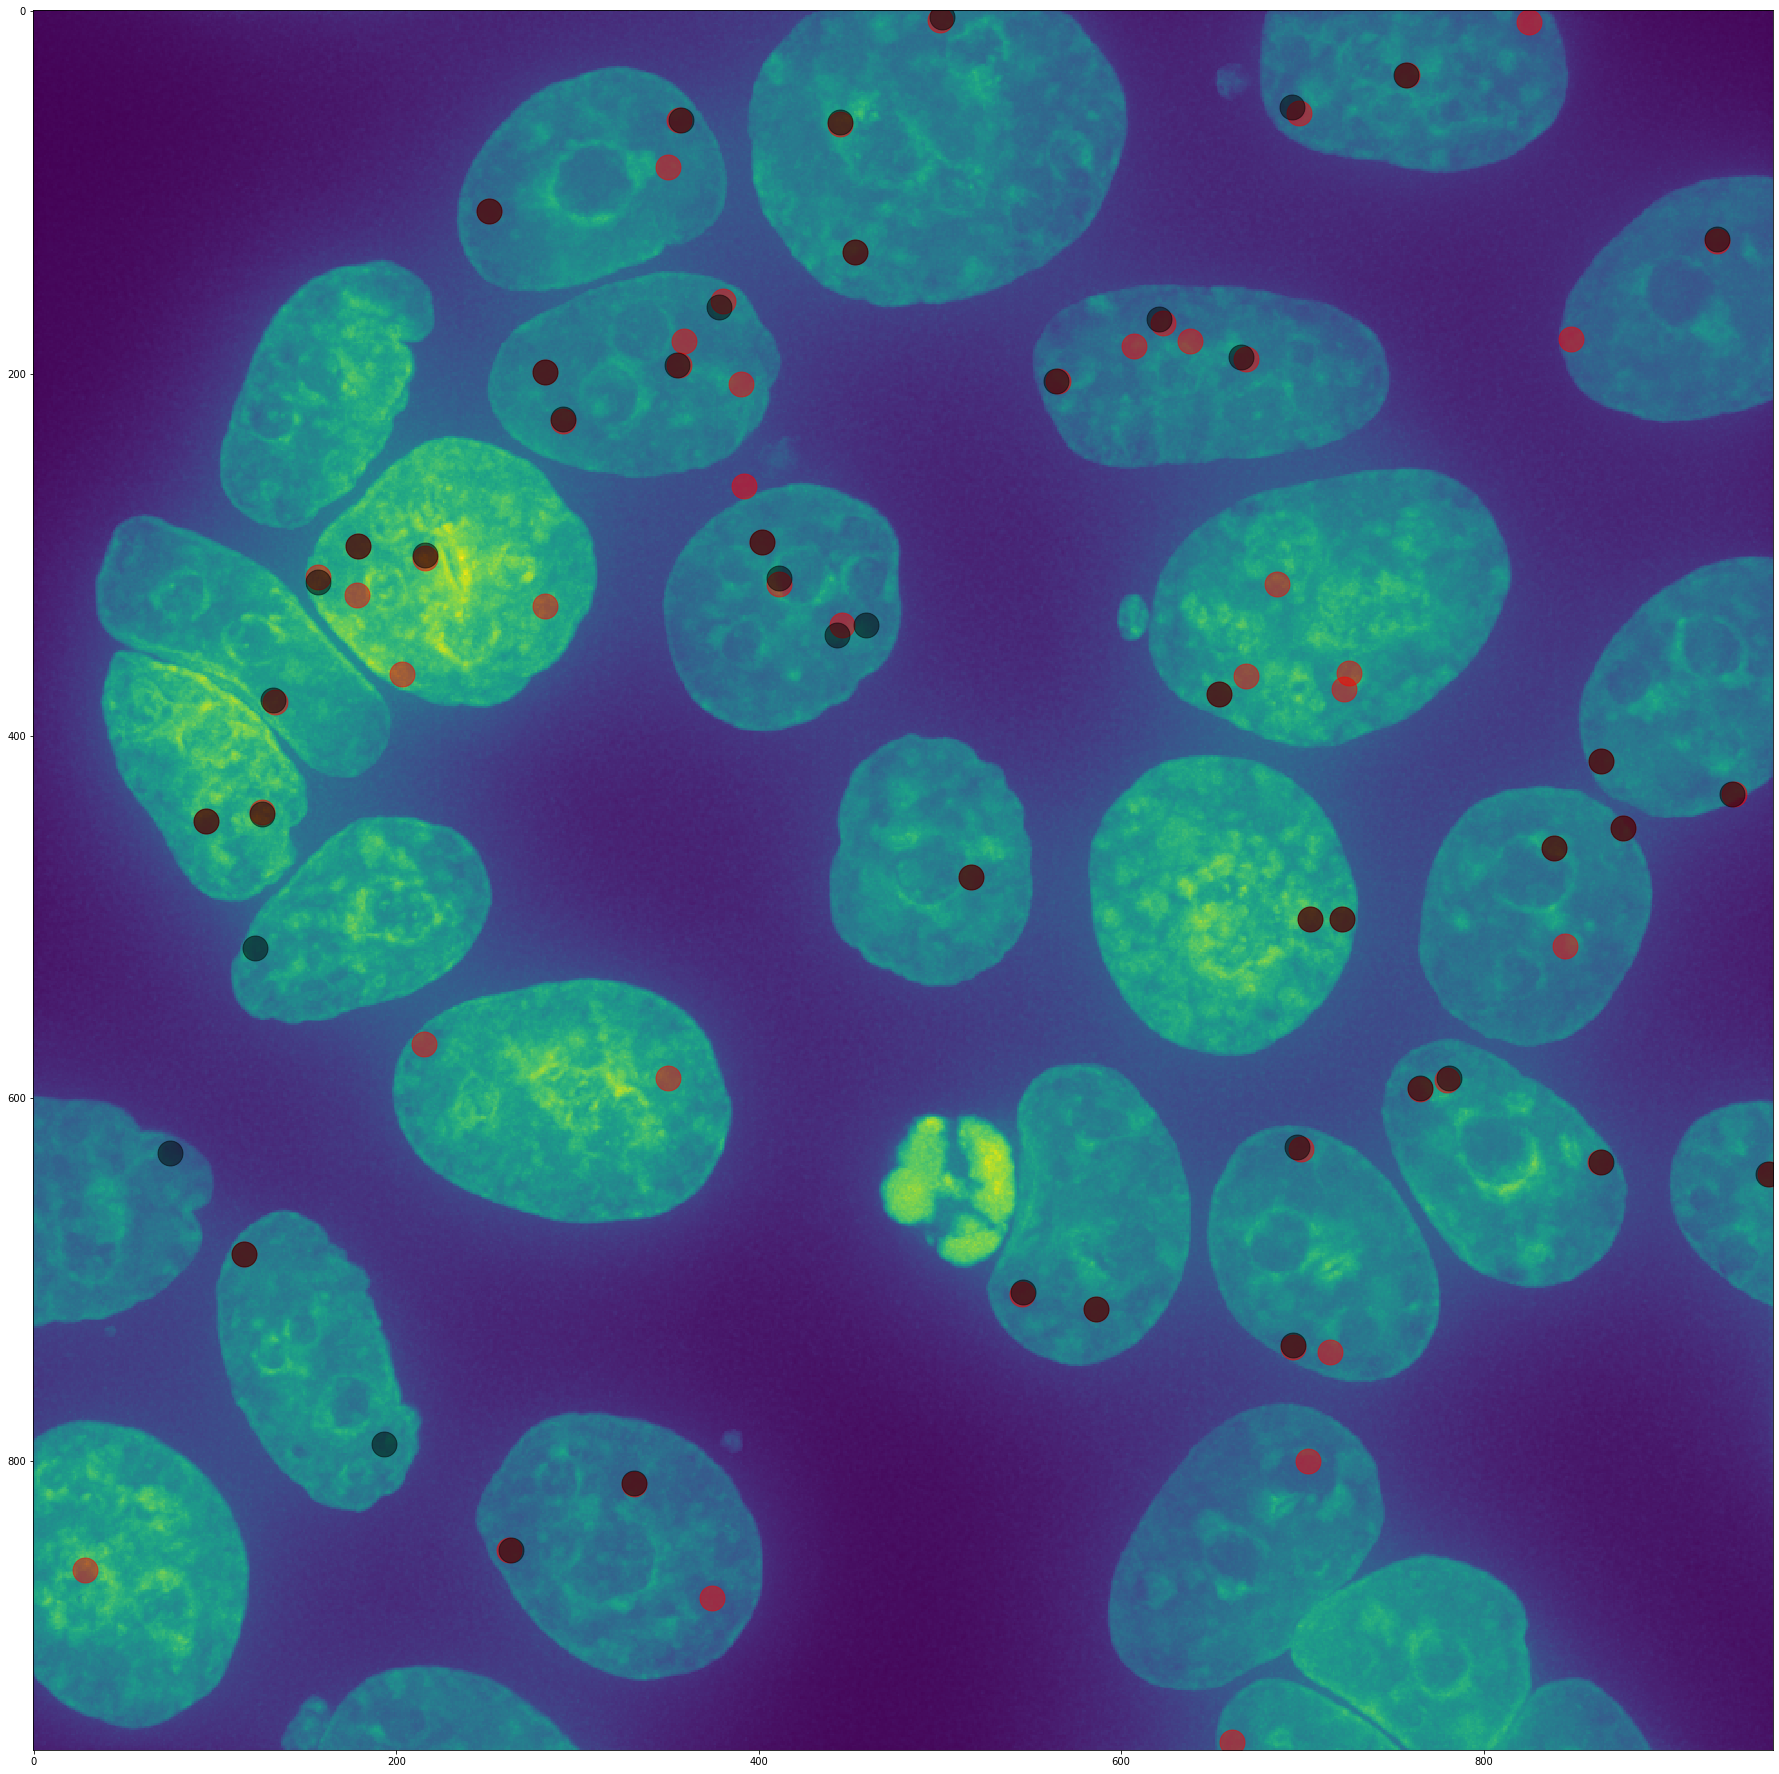

In [58]:
ntol1 = 100
img_data = np.array(ch1)
img_data = (img_data/np.max(img_data))*255
local_max = find_local_maxima_np(img_data)
ych1,xch1, out = find_maxima.find_maxima(img_data, local_max.astype(np.uint8),ntol1)
#plt.figure(figsize= (32,32))
#plt.plot(xch1,ych1,'ro')
#plt.imshow(img_data)

ntol1 = 100
img_data = np.array(ch2)
img_data = (img_data/np.max(img_data))*255
local_max = find_local_maxima_np(img_data)
ych2,xch2, out = find_maxima.find_maxima(img_data, local_max.astype(np.uint8),ntol1)
#plt.figure(figsize= (32,32))
#plt.plot(xch2,ych2,'ro')
#plt.imshow(img_data)

cell_ch1 = []
cell_ch2 = []

for i in range(0, num):
    cell_ch1.append([])
    cell_ch2.append([])
    bint = labels == i+1
    for yc1,xc1 in zip(ych1,xch1):
        if bint[yc1,xc1] == 1:
            cell_ch1[i].append([yc1,xc1])
    for yc2, xc2 in zip(ych2,xch2):
        if bint[yc2,xc2] == 1:
            cell_ch2[i].append([yc2,xc2]) 
df['pts_ch1'] = cell_ch1
df['pts_ch2'] = cell_ch2

coloc_num = []
for i in range(1,num+1):
    cell_ch1 = list(df[df['cell_num']==i]['pts_ch1'])[0]
    cell_ch2 = list(df[df['cell_num']==i]['pts_ch2'])[0]
    
    count =0
    for pts1 in cell_ch1:
        for pts2 in cell_ch2:
            dist = np.sqrt((pts1[0]-pts2[0])**2 + (pts1[1]-pts2[1])**2)
            if dist < 10:
                count +=1
    coloc_num.append(count)
df['coloc_num'] = coloc_num
plt.figure(figsize=(32,32))
plt.plot(xch1,ych1,'ro',alpha=0.5,markersize=25)
plt.plot(xch2,ych2,'ko',alpha=0.5,markersize=25)
plt.imshow(ch0)


### Visualisation of Pandas output table

In [59]:
df

,img,cell_num,pts_ch1,pts_ch2,coloc_num
0,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,1,"[[35, 758], [56, 698]]","[[35, 757], [53, 694]]",2
1,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,2,"[[5, 500], [62, 445], [133, 453]]","[[3, 501], [61, 445], [133, 453]]",3
2,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,3,"[[60, 356], [86, 350], [110, 251]]","[[60, 357], [110, 251]]",2
3,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,4,"[[127, 929], [181, 848]]","[[126, 929]]",1
4,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,5,"[[160, 380], [182, 359], [195, 356], [199, 282...","[[163, 378], [195, 355], [199, 282], [225, 292]]",4
5,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,6,"[[172, 623], [182, 638], [185, 607], [192, 669...","[[170, 621], [191, 666], [204, 564]]",3
6,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,7,"[[295, 179], [302, 216], [312, 157], [322, 178...","[[295, 179], [300, 216], [315, 157]]",3
7,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,8,"[[293, 402], [316, 411], [339, 446]]","[[293, 402], [313, 411], [339, 459], [344, 443]]",3
8,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,9,"[[316, 686], [365, 726], [367, 669], [374, 723...","[[377, 654]]",1
9,2020_0618_MCF7_E2_2Hr_07_R3D_D3D_PRJ,10,"[[414, 865], [432, 938]]","[[414, 865], [432, 937]]",2
